In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.04, identitity_weight_decay=0.92)

created reasoner with 4493 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 1.1200 | val loss 0.6834 | acc 0.7793 | f1 0.1151 | prec 0.3898 | recall 0.0675 | roc auc 0.4594 | pr auc 0.2281 | elapsed 38.15s
train epoch 01/10 | batch 1704/1703 | loss 0.8753 | val loss 0.5227 | acc 0.7987 | f1 0.2772 | prec 0.5853 | recall 0.1816 | roc auc 0.6117 | pr auc 0.3997 | elapsed 79.40s
train epoch 02/10 | batch 1704/1703 | loss 0.6230 | val loss 0.4604 | acc 0.8092 | f1 0.5133 | prec 0.5607 | recall 0.4734 | roc auc 0.7587 | pr auc 0.5681 | elapsed 78.23s
train epoch 03/10 | batch 1704/1703 | loss 0.4537 | val loss 0.4630 | acc 0.8119 | f1 0.5728 | prec 0.5538 | recall 0.5932 | roc auc 0.8018 | pr auc 0.6399 | elapsed 78.27s
train epoch 04/10 | batch 1704/1703 | loss 0.3565 | val loss 0.4848 | acc 0.8139 | f1 0.5945 | prec 0.5538 | recall 0.6417 | roc auc 0.8184 | pr auc 0.6758 | elapsed 77.15s
train epoch 05/10 | batch 1704/1703 | loss 0.2975 |

In [7]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 0.9153 | val loss 1.0708 | acc 0.6800 | f1 0.4061 | prec 0.3305 | recall 0.5266 | roc auc 0.6717 | pr auc 0.4486 | elapsed 6.85s
train epoch 01/10 | batch 849/848 | loss 0.7955 | val loss 0.9378 | acc 0.7138 | f1 0.4463 | prec 0.3731 | recall 0.5551 | roc auc 0.7017 | pr auc 0.4799 | elapsed 12.83s
train epoch 02/10 | batch 849/848 | loss 0.5700 | val loss 0.8406 | acc 0.7347 | f1 0.4739 | prec 0.4029 | recall 0.5753 | roc auc 0.7293 | pr auc 0.5123 | elapsed 13.16s
train epoch 03/10 | batch 849/848 | loss 0.4144 | val loss 0.7719 | acc 0.7501 | f1 0.4931 | prec 0.4261 | recall 0.5850 | roc auc 0.7519 | pr auc 0.5426 | elapsed 12.23s
train epoch 04/10 | batch 849/848 | loss 0.3136 | val loss 0.7235 | acc 0.7642 | f1 0.5161 | prec 0.4499 | recall 0.6052 | roc auc 0.7695 | pr auc 0.5699 | elapsed 13.03s
train epoch 05/10 | batch 849/848 | loss 0.2493 | val loss 0.6894 | acc 0.7761 | f1 0.5366 | prec 0.4706 | recall 0.6240 | roc au

In [8]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240715T230558


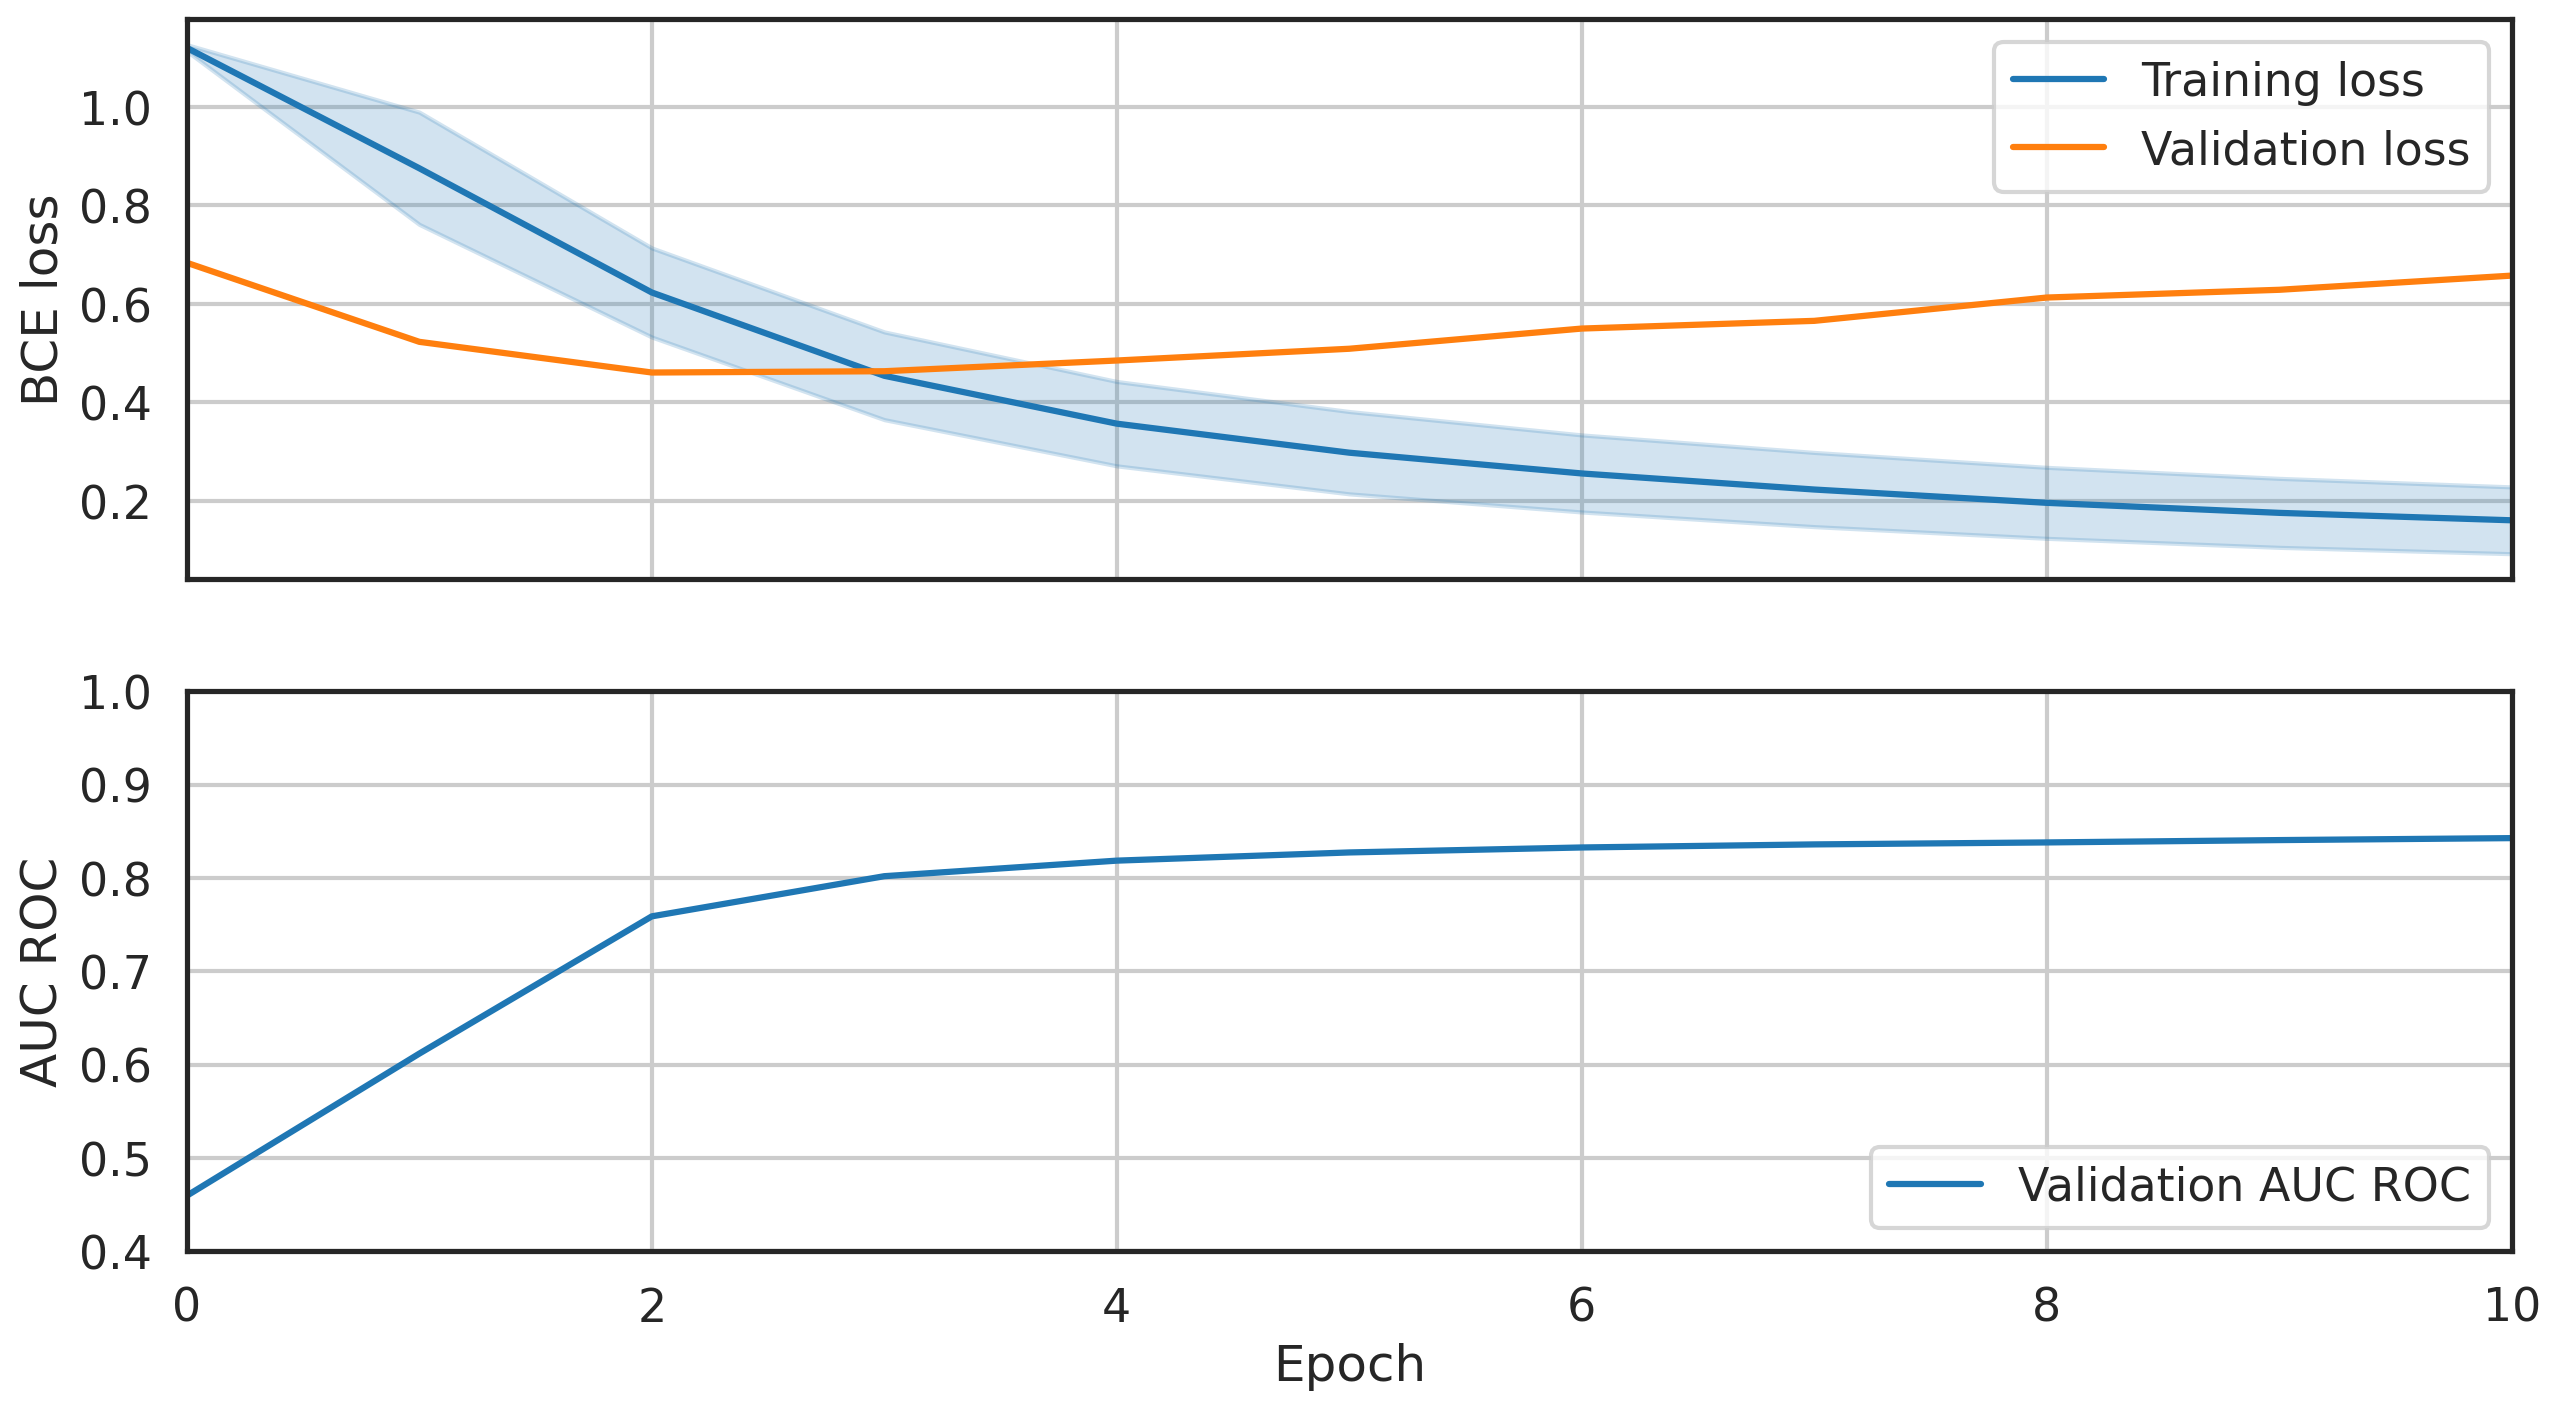

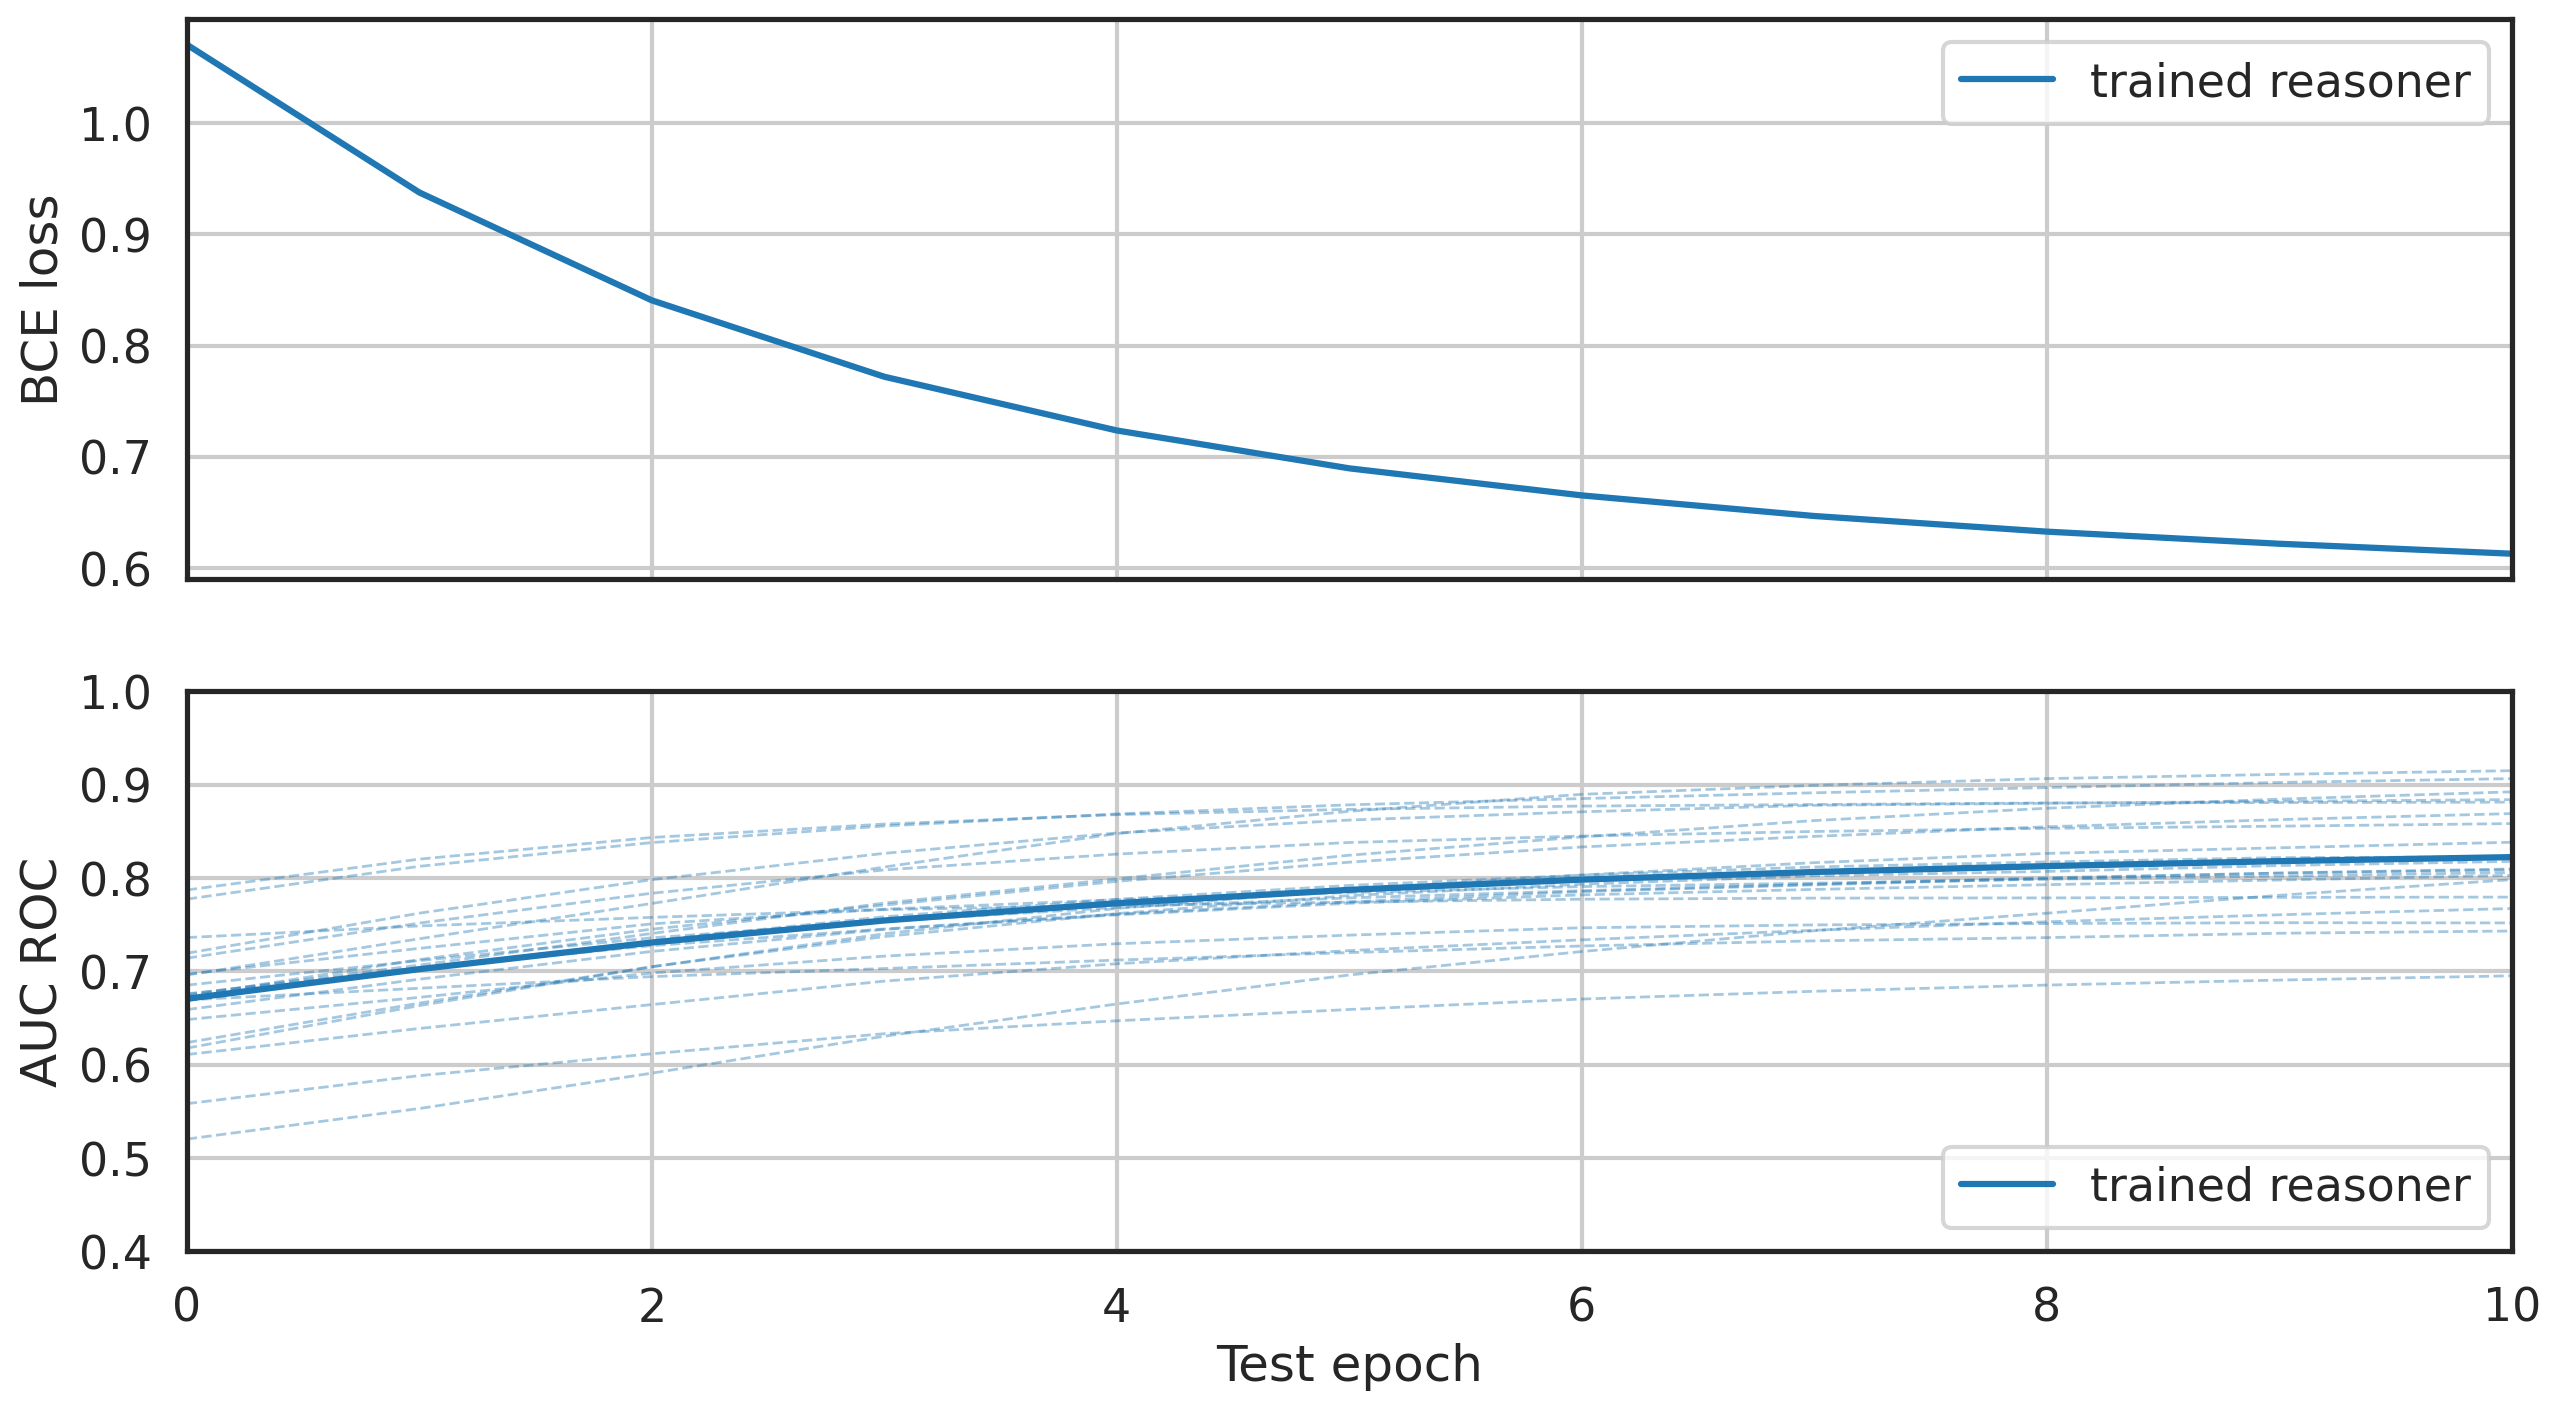

             mean       std     micro
acc      0.821602  0.046180  0.821528
prec     0.566780  0.105666  0.557035
recall   0.722247  0.086458  0.714710
f1       0.626966  0.075383  0.626098
auc_roc  0.842226  0.055748  0.836655
auc_pr   0.732665  0.081869  0.718396


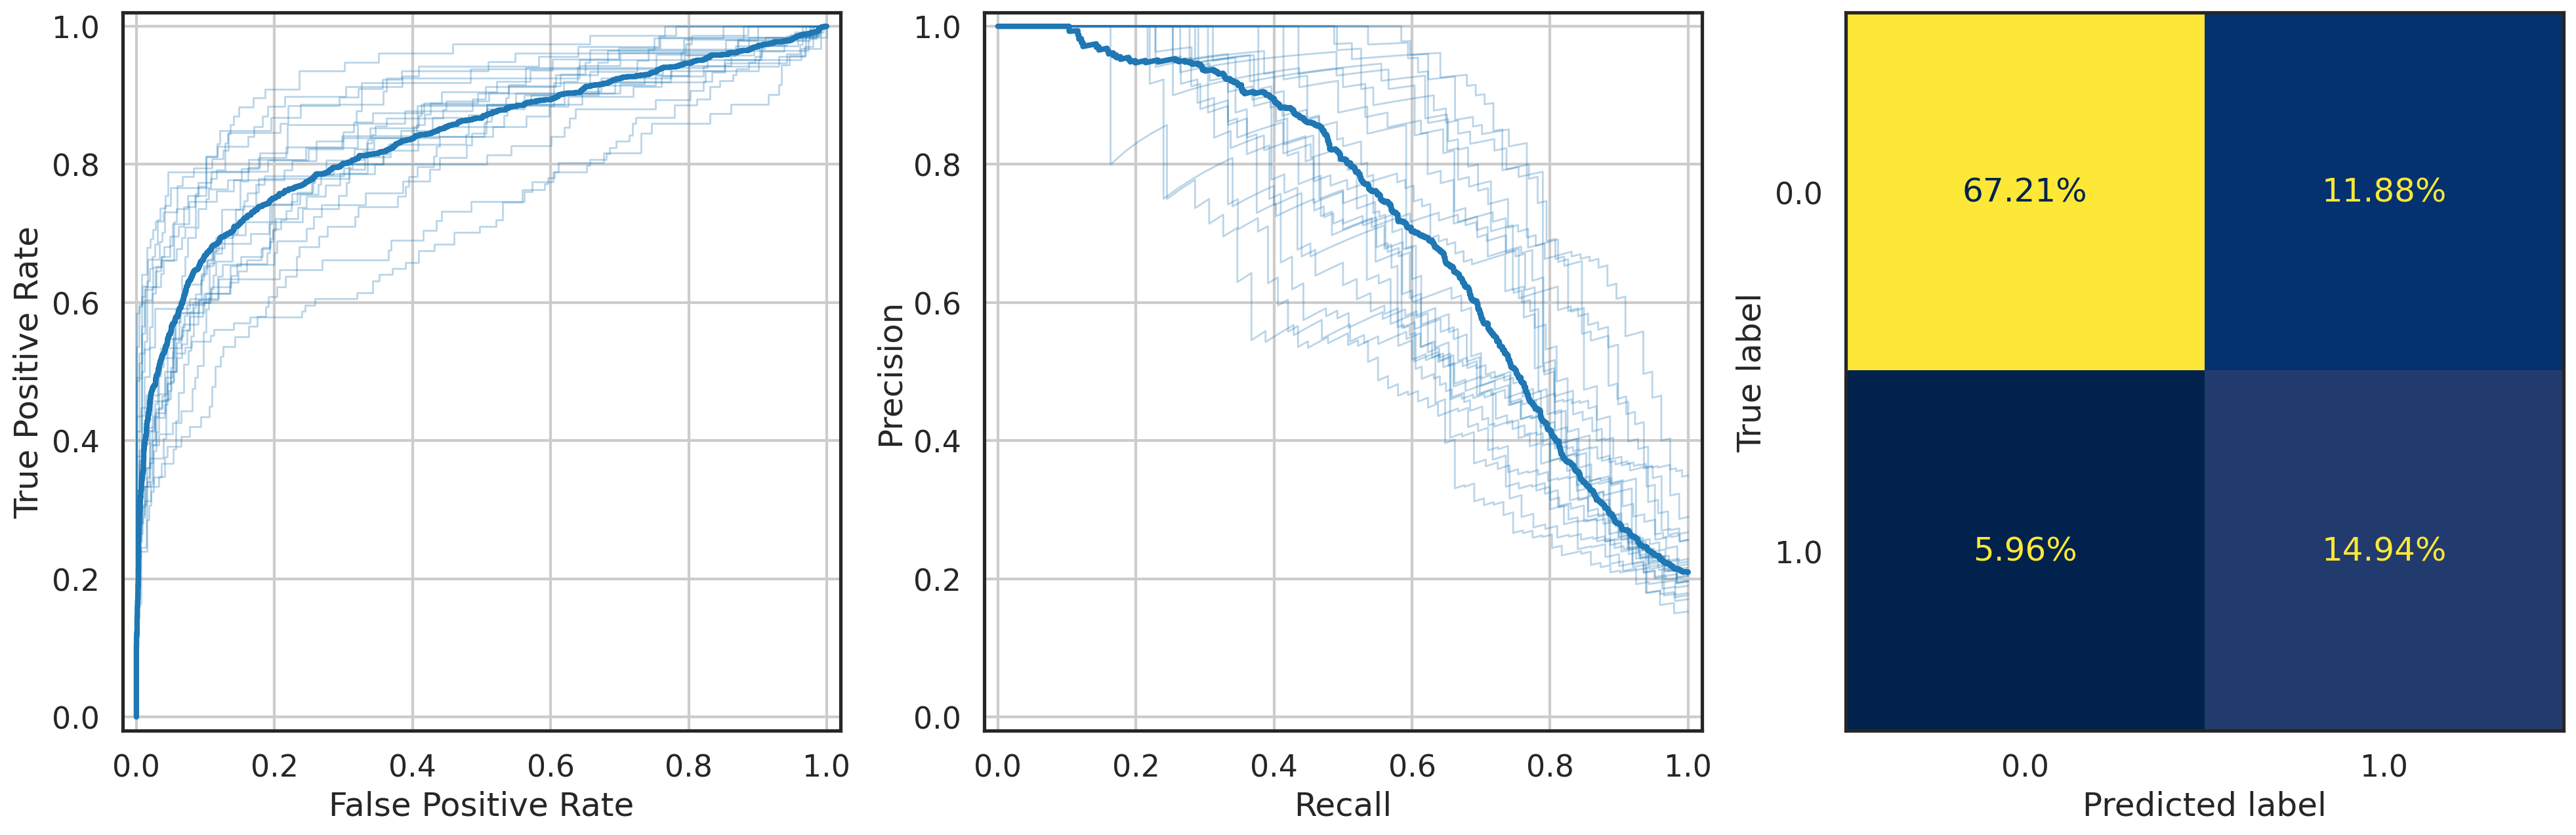

In [9]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [10]:
import random

In [11]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([ 0.0387, -0.0906, -0.1311,  0.1178, -0.1309, -0.0134, -0.0346,  0.0895,
         0.1436,  0.0384], grad_fn=<SelectBackward0>)
tensor([ 0.0956, -0.0959,  0.0987, -0.0187,  0.1547, -0.0173, -0.0038, -0.0865,
         0.0527,  0.0114], grad_fn=<AddBackward0>)
0.11346165351569652


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.4282, -0.6747,  0.2260,  0.2709,  0.3282,  0.1421,  0.6107, -0.5562,
        -0.0651, -0.1073], grad_fn=<SelectBackward0>)
tensor([ 0.2907, -0.3734,  0.3099,  0.2308,  0.3767,  0.2573,  0.1937, -0.2945,
         0.3725, -0.3013], grad_fn=<AddBackward0>)
0.1900680512189865


In [13]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.1419,  0.0468,  0.0371,  0.0860,  0.1464,  0.1682,  0.1056, -0.1910,
         0.1978, -0.2049], grad_fn=<SelectBackward0>)
tensor([ 0.1090, -0.2277,  0.1392, -0.0192,  0.2314,  0.1368,  0.1328, -0.2435,
         0.0749,  0.0010], grad_fn=<AddBackward0>)
0.11646352224051952


In [14]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.4282, -0.6747,  0.2260,  0.2709,  0.3282,  0.1421,  0.6107, -0.5562,
        -0.0651, -0.1073], grad_fn=<SelectBackward0>)
tensor([ 0.1086,  0.0307,  0.0404, -0.0172,  0.1442, -0.0786, -0.0478, -0.0555,
        -0.0631,  0.0538], grad_fn=<AddBackward0>)
0.2820585899055004


In [15]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.4282, -0.6747,  0.2260,  0.2709,  0.3282,  0.1421,  0.6107, -0.5562,
        -0.0651, -0.1073], grad_fn=<SelectBackward0>)
tensor([ 0.4281, -0.6746,  0.2261,  0.2710,  0.3281,  0.1421,  0.6106, -0.5561,
        -0.0651, -0.1074], grad_fn=<SqueezeBackward3>)
tensor(8.4648e-05, grad_fn=<L1LossBackward0>)


In [16]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.2355,  0.1037, -0.2492, -0.2214, -0.3031, -0.4720,  0.2985, -0.1454,
         0.0648,  0.5007], grad_fn=<SelectBackward0>)
tensor([-0.2356,  0.1036, -0.2491, -0.2213, -0.3031, -0.4720,  0.2988, -0.1456,
         0.0648,  0.5007], grad_fn=<SqueezeBackward3>)


tensor(7.5758e-05, grad_fn=<L1LossBackward0>)


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1346, -0.1287,  0.1003,  0.0787,  0.1950,  0.0663,  0.0382, -0.1040,
         0.0052,  0.0139], grad_fn=<AddBackward0>)
tensor([ 0.1274, -0.1309,  0.1121,  0.0544,  0.1928,  0.0669,  0.0701, -0.1004,
         0.0445, -0.0470], grad_fn=<AddBackward0>)
0.0246806968934834


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.0671, -0.0552,  0.0987, -0.0154,  0.1185, -0.0323, -0.0415, -0.0425,
        -0.0351,  0.0475], grad_fn=<AddBackward0>)
tensor([ 0.0752, -0.0386,  0.0754,  0.0169,  0.1336, -0.0127, -0.0571, -0.0565,
        -0.0423,  0.0071], grad_fn=<AddBackward0>)
0.026225549867376685


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.3495,  0.1199,  0.0443,  0.0788, -0.0168, -0.0099,  0.0084, -0.1057,
        -0.1101, -0.0606], grad_fn=<SelectBackward0>)
tensor([-0.1003,  0.0468,  0.0140, -0.0565, -0.0467, -0.1227, -0.0847,  0.0527,
        -0.0792,  0.1586], grad_fn=<AddBackward0>)
0.1033708818256855


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.998760923743248


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

1.0


In [22]:
or_nn=trained_reasoner.or_nn
top = trained_reasoner.top_concept
bot = trained_reasoner.bot_concept
and_nn = trained_reasoner.and_nn
not_nn = trained_reasoner.not_nn

loss =0
loss += F.mse_loss(top[0], or_nn(im_mod(input1, not_nn(input1))))
loss += F.mse_loss(top[0], or_nn(im_mod(input2, not_nn(input2))))
loss += F.mse_loss(top[0], or_nn(im_mod(input3, not_nn(input3))))

loss += F.mse_loss(top[0], or_nn(im_mod(not_nn(input1), input1)))
loss += F.mse_loss(top[0], or_nn(im_mod(not_nn(input2), input2)))
loss += F.mse_loss(top[0], or_nn(im_mod(not_nn(input3), input3)))

# Prawa de Morgana: ¬(A ⊔ B) = ¬A ⊓ ¬B
loss += F.mse_loss(not_nn(or_nn(im_mod(input1, input2))), 
            and_nn(im_mod(not_nn(input1), not_nn(input2))))
# Przykład 2
loss += F.mse_loss(not_nn(or_nn(im_mod(input2, input3))), 
            and_nn(im_mod(not_nn(input2), not_nn(input3))))
# Przykład 3
loss += F.mse_loss(not_nn(or_nn(im_mod(input1, input3))), 
            and_nn(im_mod(not_nn(input1), not_nn(input3))))

# Obustronnie zanegowana opcja: ¬(A ⊔ B) = ¬A ⊓ ¬B
# Przykład 1
loss += F.mse_loss(or_nn(im_mod(input1, input2)), 
            not_nn(and_nn(im_mod(not_nn(input1), not_nn(input2)))))
# Przykład 2
loss += F.mse_loss(or_nn(im_mod(input2, input3)), 
            not_nn(and_nn(im_mod(not_nn(input2), not_nn(input3)))))
# Przykład 3
loss += F.mse_loss(or_nn(im_mod(input1, input3)), 
            not_nn(and_nn(im_mod(not_nn(input1), not_nn(input3)))))

# Prawa de Morgana: ¬(A ⊓ B) = ¬A ⊔ ¬B
# Przykład 1
loss += F.mse_loss(not_nn(and_nn(im_mod(input1, input2))), 
            or_nn(im_mod(not_nn(input1), not_nn(input2))))
# Przykład 2
loss += F.mse_loss(not_nn(and_nn(im_mod(input2, input3))), 
            or_nn(im_mod(not_nn(input2), not_nn(input3))))
# Przykład 3
loss += F.mse_loss(not_nn(and_nn(im_mod(input1, input3))), 
            or_nn(im_mod(not_nn(input1), not_nn(input3))))

# Prawa absorpcji: A ⊔ (A ⊓ B) = A
loss += F.mse_loss(input1, or_nn(im_mod(input1, and_nn(im_mod(input1, input2)))))
loss += F.mse_loss(input1, or_nn(im_mod(and_nn(im_mod(input2, input1)), input2)))

loss += F.mse_loss(input1, or_nn(im_mod(input1, and_nn(im_mod(input1, input3)))))
loss += F.mse_loss(input1, or_nn(im_mod(and_nn(im_mod(input3, input1)), input3)))

# Dla input2
loss += F.mse_loss(input2, or_nn(im_mod(input2, and_nn(im_mod(input2, input1)))))
loss += F.mse_loss(input2, or_nn(im_mod(and_nn(im_mod(input1, input2)), input1)))
loss += F.mse_loss(input2, or_nn(im_mod(input2, and_nn(im_mod(input2, input3)))))
loss += F.mse_loss(input2, or_nn(im_mod(and_nn(im_mod(input3, input2)), input3)))

# Dla input3
loss += F.mse_loss(input3, or_nn(im_mod(input3, and_nn(im_mod(input3, input1)))))
loss += F.mse_loss(input3, or_nn(im_mod(and_nn(im_mod(input1, input3)), input1)))
loss += F.mse_loss(input3, or_nn(im_mod(input3, and_nn(im_mod(input3, input2)))))
loss += F.mse_loss(input3, or_nn(im_mod(and_nn(im_mod(input2, input3)), input2)))

# Prawa dystrybucji: A ⊔ (B ⊓ C) = (A ⊔ B) ⊓ (A ⊔ C)
loss += F.mse_loss(or_nn(im_mod(input1, and_nn(im_mod(input2, input3)))),
            and_nn(im_mod(or_nn(im_mod(input1, input2)), or_nn(im_mod(input1, input3)))))
loss += F.mse_loss(or_nn(im_mod(input2, and_nn(im_mod(input1, input3)))),
        and_nn(im_mod(or_nn(im_mod(input2, input1)), or_nn(im_mod(input2, input3)))))
loss += F.mse_loss(or_nn(im_mod(input3, and_nn(im_mod(input2, input1)))),
        and_nn(im_mod(or_nn(im_mod(input3, input2)), or_nn(im_mod(input3, input1)))))

# Właściwości zbioru pustego i pełnego z OR
loss += F.mse_loss(input1, or_nn(im_mod(input1, bot[0])))
loss += F.mse_loss(input2, or_nn(im_mod(input2, bot[0])))
loss += F.mse_loss(input3, or_nn(im_mod(input3, bot[0])))
# Input po prawej stronie im_mod
loss += F.mse_loss(input1, or_nn(im_mod(bot[0], input1)))
loss += F.mse_loss(input2, or_nn(im_mod(bot[0], input2)))
loss += F.mse_loss(input3, or_nn(im_mod(bot[0], input3)))

# Input po lewej stronie im_mod
loss += F.mse_loss(top[0], or_nn(im_mod(input1, top[0])))
loss += F.mse_loss(top[0], or_nn(im_mod(input2, top[0])))
loss += F.mse_loss(top[0], or_nn(im_mod(input3, top[0])))
# Input po prawej stronie im_mod
loss += F.mse_loss(top[0], or_nn(im_mod(top[0], input1)))
loss += F.mse_loss(top[0], or_nn(im_mod(top[0], input2)))
loss += F.mse_loss(top[0], or_nn(im_mod(top[0], input3)))

# Właściwości kommutatywności i łączności dla OR
loss += F.mse_loss(or_nn(im_mod(input1, input2)), or_nn(im_mod(input2, input1)))  # A ⊔ B = B ⊔ A
loss += F.mse_loss(or_nn(im_mod(input3, input1)), or_nn(im_mod(input1, input3)))  # A ⊔ B = B ⊔ A
loss += F.mse_loss(or_nn(im_mod(input2, input3)), or_nn(im_mod(input3, input2)))  # A ⊔ B = B ⊔ A

loss += F.mse_loss(or_nn(im_mod(input1, or_nn(im_mod(input2, input3)))),
            or_nn(im_mod(or_nn(im_mod(input1, input2)), input3)))  # A ⊔ (B ⊔ C) = (A ⊔ B) ⊔ C
loss += F.mse_loss(or_nn(im_mod(input3, or_nn(im_mod(input1, input2)))),
            or_nn(im_mod(or_nn(im_mod(input1, input3)), input2)))  # A ⊔ (B ⊔ C) = (A ⊔ B) ⊔ C
loss += F.mse_loss(or_nn(im_mod(input2, or_nn(im_mod(input1, input3)))),
            or_nn(im_mod(or_nn(im_mod(input2, input3)), input1)))  # A ⊔ (B ⊔ C) = (A ⊔ B) ⊔ C